In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

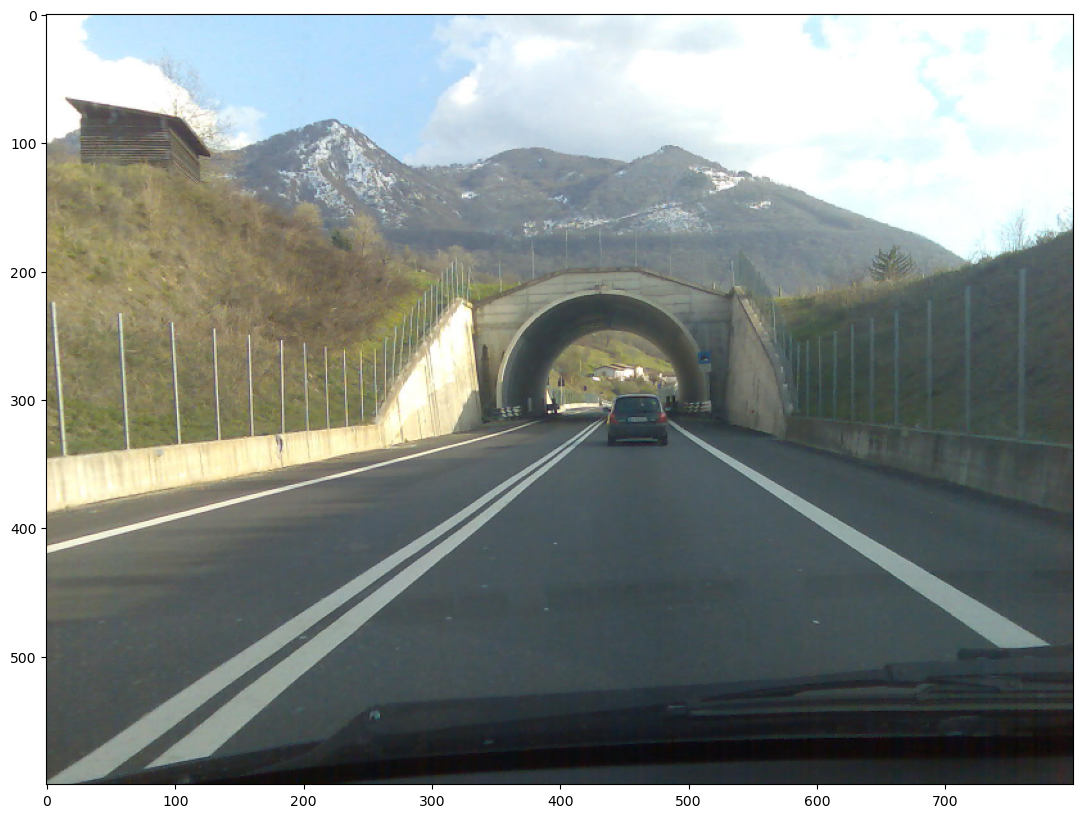

In [2]:
img = cv2.imread('road.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

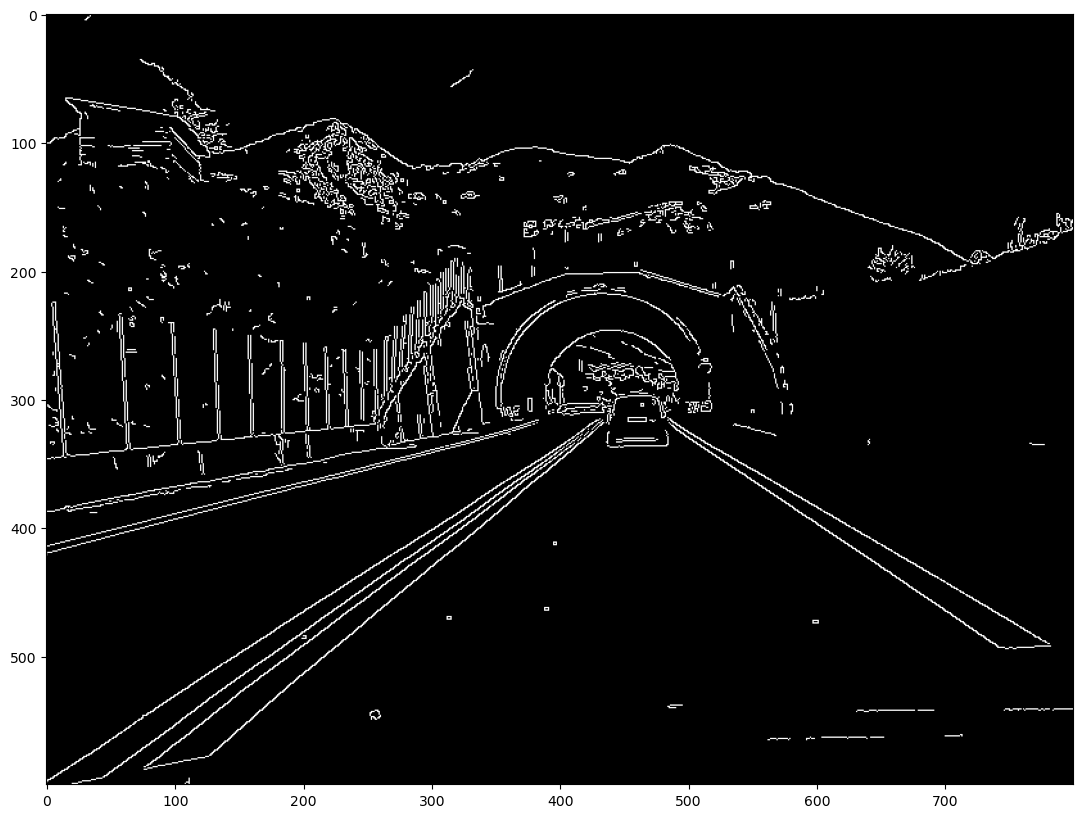

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)
plt.imshow(edges, cmap='gray')

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0



(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

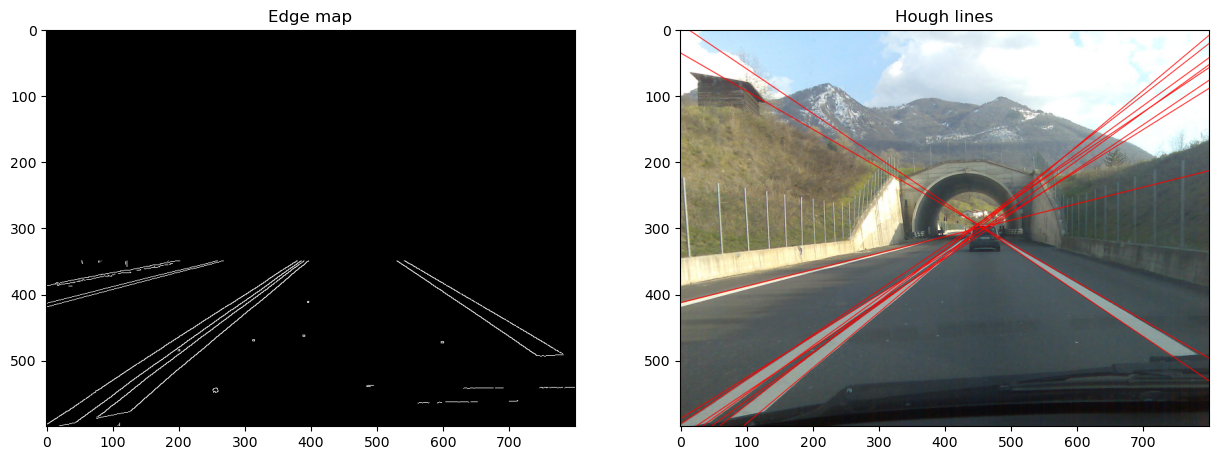

In [6]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190

lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)
hough = np.zeros_like(edges)
result = np.copy(img)

        
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)

    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')
    


In [8]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
theta_min = 70* np.pi/180
theta_max = 110* np.pi/180
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[0][1]
    # Keep line if theta is not horizontal
    if theta < theta_min or theta > theta_max:
        filtered_lines.append(line)
print(len(filtered_lines))

9


(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

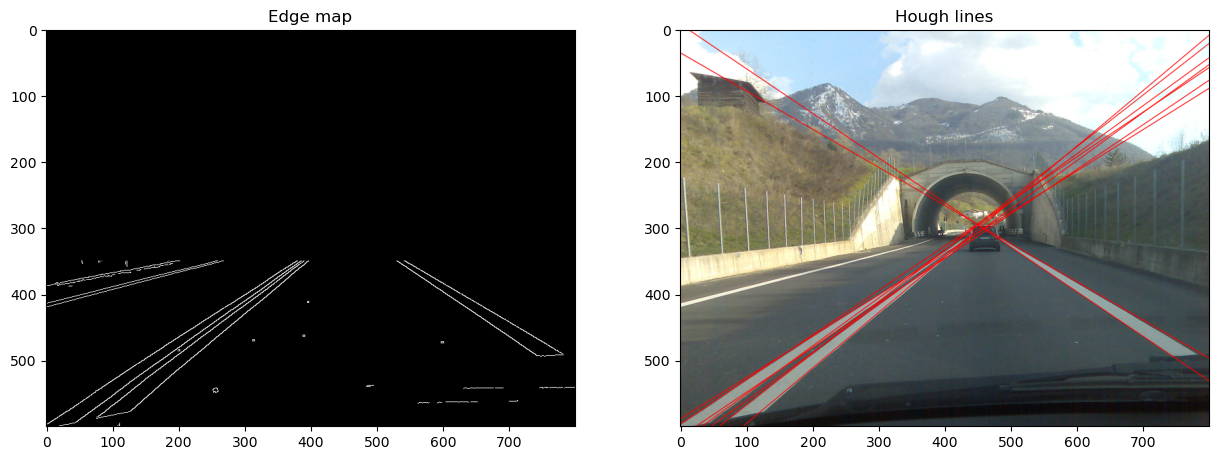

In [9]:
result = np.copy(img)
hough = np.zeros_like(edges)
for i in range (len(filtered_lines)):
    rho = filtered_lines[i][0][0]
    theta = filtered_lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [11]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
filtered_lines = filtered_lines[:, 0, :]
filtered_lines = np.array(filtered_lines)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[511.        ,   0.94247776],
       [ -7.        ,   2.1642082 ],
       [ 31.        ,   2.0943952 ],
       [497.        ,   0.99483764],
       [521.        ,   0.87266463],
       [505.        ,   0.94247776]], dtype=float32)

In [12]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for i in kmeans.cluster_centers_:
    i = i.astype(np.int64)
    rho = kmeans.cluster_centers_[i][0]
    theta = kmeans.cluster_centers_[i][1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')



IndexError: index 511 is out of bounds for axis 0 with size 6